<a href="https://colab.research.google.com/github/ioadeer/bi-bycing-ba-2021/blob/main/bicing_2020_2021_clima_rutas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movilidad Sustentable
## Ciencia de Datos e Inteligencia de Negocios


### Configuración

In [1]:
"""
Bicicletas: Recorridos
Clima: PRCP TAVG TEMP[C] HUM[%] PNM[hPa] DD[gr] FF[km/hr]                                                 
2020-2021
Data acquisition & wrangling
"""
import os
import sys
import urllib.request

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime
# from datetime import date, timedelta
import re

datadir = 'datasets/'

In [2]:
# from google.colab import drive
# drive.mount(
#   '/content/drive/', 
#   # force_remount = True
# )
# if drive:
#   datadir = '/content/drive/MyDrive/Academicos/UTN/BI/datasets/'

# Adquisición


In [3]:
insumos = {
  "recorridos-2020" : {
    "remote" : 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte/bicicletas-publicas/recorridos-realizados-2020.zip',
    "local" : datadir + 'recorridos-realizados-2020.zip',
    "df" : pd.DataFrame(),
  },
  "recorridos-2021" : {
    "remote" : 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte/bicicletas-publicas/recorridos-realizados-2021.zip',   
    "local" : datadir + 'recorridos-realizados-2021.zip',
    "df" : pd.DataFrame(),
  },
  "clima" : {
    "remote" : '',   
    "local" : datadir + 'weather-data-ba.csv',
    "df" : pd.DataFrame(),
  },
  "estaciones" : {
    "remote" : 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte/estaciones-bicicletas-publicas/nuevas-estaciones-bicicletas-publicas.xlsx',   
    "local" : datadir + 'nuevas_estaciones.xlsx',
    "df" : pd.DataFrame(),
  },
#   "rutas" : {
#     "remote" : '',   
#     "local" : datadir + 'rutas.csv',
#     "df" : pd.DataFrame(),
#   },
}

In [4]:
"""
Cargar insumos
"""
def cargar_insumos( insumos ):
    for i in insumos:
        if not os.path.exists( insumos[i]["local"] ):
            print("Descargando:", insumos[i]["remote"])
            urllib.request.urlretrieve(
              insumos[i]["remote"],
              insumos[i]["local"]
            )
        if "zip" in insumos[i]["local"]:
            insumos[i]["df"] = pd.read_csv(
                insumos[i]["local"],
                compression = 'zip',
                encoding = 'utf-8', 
            )
        if "csv" in insumos[i]["local"]:
            insumos[i]["df"] = pd.read_csv(
                insumos[i]["local"],
            )
        if "xlsx" in insumos[i]["local"]:
            insumos[i]["df"] = pd.read_excel(
                insumos[i]["local"],
            )
        print( 'Cargado: ', insumos[i]["local"] )
    return insumos

In [5]:
insumos = cargar_insumos( insumos )

Cargado:  datasets/recorridos-realizados-2020.zip
Cargado:  datasets/recorridos-realizados-2021.zip
Cargado:  datasets/weather-data-ba.csv
Cargado:  datasets/nuevas_estaciones.xlsx
Cargado:  datasets/rutas.csv


# Subproductos

In [6]:
derivados = {
  "recorridos" : {
    "df"     : pd.DataFrame(),
    "local"  : datadir + 'recorridos.csv',
    "remote" : '',   
  },
  "vueltas" : {
    "df"     : pd.DataFrame(),
    "local"  : datadir + 'vueltas.csv',
    "remote" : '',   
  },
  "estaciones" : {
    "df"     : pd.DataFrame(),
    "local"  : datadir + 'estaciones.csv',
    "remote" : '',   
  },
  "distancias" : {
    "df"     : pd.DataFrame(),
    "local"  : datadir + 'distancias_estaciones.csv',
    "remote" : '',   
  },
  "rutas" : {
    "df"     : pd.DataFrame(),
    "local"  : datadir + 'rutas.csv',
    "remote" : '',   
  },
  "clima" : {
    "df"     : pd.DataFrame(),
    "local"  : datadir + 'clima_datohorario_2020_2021.csv', 
    "remote" : '',
  },
  "pronostico" : {
    "df"     : pd.DataFrame(),
    "local"  : datadir + 'pronostico_2020_2021.csv', 
    "remote" : '',
  },
}

 ## Normalizacion

In [7]:
# renombrar y filtrar columnas  2021
encabezados2021 = {
    'ID'                                  : 'id',
    'Duración'                            : 'duracion_recorrido',
    'Estado cerrado'                      : 'estado_cerrado',
    'ID de ciclista'                      : 'id_usuario',
    'Tipo de ciclista'                    : 'cilicsta_tipo',
    'Modelo de bicicleta'                 : 'bicicleta_modelo',   
    'Id de estación de inicio'            : 'id_estacion_origen', 
    'Nombre de estación de inicio'        : 'nombre_estacion_origen',
    'Fecha de inicio'                     : 'fecha_origen_recorrido',     
    'Origen de viaje'                     : 'direccion_estacion_origen',  
#     'lon_estacion_origen'                : 'lon_estacion_origen',        
#     'lat_estacion_origen'                 : 'lat_estacion_origen',
    'Id de estación de fin de viaje'      : 'id_estacion_destino',     
    'Nombre de estación de fin de viaje'  : 'nombre_estacion_destino',
    'Fecha de fin'                        : 'fecha_destino_recorrido',          
#     'direccion_estacion_destino'          : 'direccion_estacion_origen',           
#     'lon_estacion_destino'               : 'lon_estacion_destino',       
#     'lat_estacion_destino'                : 'lat_estacion_destino',
#     'periodo'                             : 'periodo',  
}
insumos["recorridos-2021"]["df"] = insumos["recorridos-2021"]["df"].rename( 
    columns = encabezados2021
)
insumos["recorridos-2021"]["df"]["id"] = insumos["recorridos-2021"]["df"]['id'].astype('Int64')

In [8]:
# Concatenar recorridos 2020:2021
recorridos = [
    insumos["recorridos-2020"]["df"],
    insumos["recorridos-2021"]["df"]
]
derivados["recorridos"]["df"] = pd.concat( recorridos )
del recorridos  

In [9]:
encabezados = {
    'id'                         : 'id',
    'duracion_recorrido'         : 'duracion',
    'estado_cerrado'             : 'estado_cerrado',
    'id_usuario'                 : 'usuario_id',
#     'cilicsta_tipo'            : 'cilicsta_tipo',
#     'bicicleta_modelo'         : 'bicicleta_modelo',   
    'id_estacion_origen'         : 'origen_id', 
    'nombre_estacion_origen'     : 'origen_nombre',
    'fecha_origen_recorrido'     : 'origen_fecha',     
    'direccion_estacion_origen'  : 'origen_direccion',
    'lat_estacion_origen'        : 'origen_lat',  
    'long_estacion_origen'       : 'origen_lon',        
    'id_estacion_destino'        : 'destino_id',     
    'nombre_estacion_destino'    : 'destino_nombre',
    'fecha_destino_recorrido'    : 'destino_fecha',          
    'direccion_estacion_destino' : 'destino_direccion', 
    'lat_estacion_destino'       : 'destino_lat',          
    'long_estacion_destino'      : 'destino_lon',       
#     'periodo'                    : 'periodo',  
}
derivados["recorridos"]["df"] = derivados["recorridos"]["df"].rename( columns = encabezados )
derivados["recorridos"]["df"] = derivados["recorridos"]["df"][ list( encabezados.values() ) ]

In [10]:
derivados["recorridos"]["df"]['destino_nombre'] = derivados["recorridos"]["df"]['destino_nombre'].fillna(
    '999 - Vacio'
)
derivados["recorridos"]["df"]['destino_nombre'] = derivados["recorridos"]["df"]['destino_nombre'].str.replace(
    'Balboa Definitivo', 
    '666 - Balboa Definitivo', 
    regex = False
)

In [11]:
"""
Separar las columnas nombre de estacion de origen y nombre de estacion de destino 
Tienen la info correcta del id de las estaciones.
Divido la columna Nombre de estacion de fin de viaje porque contiene dos campos 
el Id y el nombre de la estacion de inicio de viaje.
"""
derivados["recorridos"]["df"][
    ['origen_id','origen_nombre']
] = derivados["recorridos"]["df"]['origen_nombre'].str.split('-', expand = True )
derivados["recorridos"]["df"]['origen_id'] = derivados["recorridos"]["df"]['origen_id'].str.strip(' ')
derivados["recorridos"]["df"]['origen_nombre'] = derivados["recorridos"]["df"]['origen_nombre'].str.strip(' ')

derivados["recorridos"]["df"][
    ['destino_id','destino_nombre']
] = derivados["recorridos"]["df"]['destino_nombre'].str.split('-', expand = True )
derivados["recorridos"]["df"]['destino_id'] = derivados["recorridos"]["df"]['destino_id'].str.strip(' ')
derivados["recorridos"]["df"]['destino_nombre'] = derivados["recorridos"]["df"]['destino_nombre'].str.strip(' ')

In [12]:
derivados["recorridos"]["df"]['origen_id'] = derivados["recorridos"]["df"]["origen_id"].str.lstrip('0').astype(int)
derivados["recorridos"]["df"]['destino_id'] = derivados["recorridos"]["df"]["destino_id"].str.lstrip('0').astype(int)
derivados["recorridos"]["df"]["origen_nombre"]  = derivados["recorridos"]["df"]["origen_nombre"].str.upper()
derivados["recorridos"]["df"]["destino_nombre"]  = derivados["recorridos"]["df"]["destino_nombre"].str.upper()
derivados["recorridos"]["df"]["origen_direccion"]  = derivados["recorridos"]["df"]["origen_direccion"].str.upper()
derivados["recorridos"]["df"]["destino_direccion"]  = derivados["recorridos"]["df"]["destino_direccion"].str.upper()

In [13]:
# ESTACIONES

In [14]:
insumos["estaciones"]["df"] # raw

,WKT,id,codigo,nombre,ubicacion,tipo,horario,anclajes_t
0,POINT (-58.3747109506359 -34.5924239181221),2,2,002 - Retiro I,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
1,POINT (-58.368256111128 -34.611033074021),3,3,003 - ADUANA,Moreno & Av Paseo Colon,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
2,POINT (-58.3687766674259 -34.6018228613782),4,4,004 - Plaza Roma,Lavalle & Bouchard,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
3,POINT (-58.420951914897 -34.5805498216605),5,5,005 - Plaza Italia,Av. Sarmiento 2601,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,42
4,POINT (-58.3697538990917 -34.6285274659984),6,6,006 - Parque Lezama,"Avenida Martin Garcia, 295",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
...,...,...,...,...,...,...,...,...
224,POINT (-58.4594980806633 -34.5445021121101),396,227,227 -Club Ciudad de Buenos Aires,Miguel Sanchez y Av Libertadores,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,16
225,POINT (-58.3747959781335 -34.6098020140517),398,16,016 - Legislatura,"169 Peru & Roca, Julio A., Presidente Diagonal...",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
226,POINT (-58.370711799739 -34.6089370142298),401,61,061-Ministerio de Economia,"Balcarce & Yrigoyen, Hipolito Av.",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,24
227,POINT (-58.3788579541696 -34.5824223699167),403,393,393 - Barrio 31,Carlos H. Perette 11,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,24


In [15]:
derivados["estaciones"]["df"] = pd.DataFrame()
derivados["estaciones"]["df"]['id'] = insumos["estaciones"]["df"]['codigo']
derivados["estaciones"]["df"]['nombre'] = insumos["estaciones"]["df"]['nombre'].str.replace(
    '\d+', '',
    regex=True
).str.replace('-', '', regex=True).str.strip(' ').str.upper()
derivados["estaciones"]["df"]['oid'] = insumos["estaciones"]["df"]['id']
derivados["estaciones"]["df"]['direccion'] = insumos["estaciones"]["df"]['ubicacion'].str.upper()
derivados["estaciones"]["df"][
    ['lon','lat']
] = insumos["estaciones"]["df"]['WKT'].str.replace('POINT ','').str.lstrip('(').str.rstrip(')').str.split(' ', expand = True )
derivados["estaciones"]["df"]['anclajes'] = insumos["estaciones"]["df"]['anclajes_t']

derivados["estaciones"]["df"] # clean

,id,nombre,oid,direccion,lon,lat,anclajes
0,2,RETIRO I,2,"RAMOS MEJIA, JOSE MARIA, DR. AV. & DEL LIBERTA...",-58.3747109506359,-34.5924239181221,20
1,3,ADUANA,3,MORENO & AV PASEO COLON,-58.368256111128,-34.611033074021,20
2,4,PLAZA ROMA,4,LAVALLE & BOUCHARD,-58.3687766674259,-34.6018228613782,20
3,5,PLAZA ITALIA,5,AV. SARMIENTO 2601,-58.420951914897,-34.5805498216605,42
4,6,PARQUE LEZAMA,6,"AVENIDA MARTIN GARCIA, 295",-58.3697538990917,-34.6285274659984,20
...,...,...,...,...,...,...,...
224,227,CLUB CIUDAD DE BUENOS AIRES,396,MIGUEL SANCHEZ Y AV LIBERTADORES,-58.4594980806633,-34.5445021121101,16
225,16,LEGISLATURA,398,"169 PERU & ROCA, JULIO A., PRESIDENTE DIAGONAL...",-58.3747959781335,-34.6098020140517,20
226,61,MINISTERIO DE ECONOMIA,401,"BALCARCE & YRIGOYEN, HIPOLITO AV.",-58.370711799739,-34.6089370142298,24
227,393,BARRIO,403,CARLOS H. PERETTE 11,-58.3788579541696,-34.5824223699167,24


In [16]:
salidas = derivados["recorridos"]["df"].groupby(
    'origen_id' 
).agg(
    salidas = pd.NamedAgg( column = "origen_id", aggfunc = "count"),
).reset_index()

arribos = derivados["recorridos"]["df"].groupby(
    'destino_id'
).agg(
  arribos = pd.NamedAgg( column = "destino_id", aggfunc = "count"),
).reset_index()

salidas_arribos = pd.merge(
    left     = salidas,
    right    = arribos,
    how      = 'left',
    left_on  = ['origen_id'],
    right_on = ['destino_id']
)
derivados["estaciones"]["df"] = pd.merge(
    left     = derivados["estaciones"]["df"],
    right    = salidas_arribos,
    how      = 'left',
    left_on  = ['id','id'],
    right_on = ['origen_id','destino_id']
)
del [salidas, arribos, salidas_arribos]
derivados["estaciones"]["df"]["salidas"] = derivados["estaciones"]["df"]["salidas"].fillna(0).astype(int)
derivados["estaciones"]["df"]["arribos"] = derivados["estaciones"]["df"]["arribos"].fillna(0).astype(int)
derivados["estaciones"]["df"] = derivados["estaciones"]["df"].drop(
    columns = ['origen_id','destino_id']
)
derivados["estaciones"]["df"] = derivados["estaciones"]["df"].sort_values(
   by = ['salidas'], ascending = [False]
)
derivados["estaciones"]["df"]

,id,nombre,oid,direccion,lon,lat,anclajes,salidas,arribos
142,160,GODOY CRUZ Y LIBERTADOR,194,GODOY CRUZ 3279 Y LIBERTADOR,-58.4206256441755,-34.5725829417623,20,47822,48368
10,14,PACIFICO,13,"SANTA FE AV. & BULLRICH, INT. AV.",-58.4263849214833,-34.5774240238566,30,47577,44859
20,29,PARQUE CENTENARIO,27,AV. PATRICIAS ARGENTINAS & ESTIVAO,-58.4335557423123,-34.6079420843387,30,46426,44650
172,292,PLAZA BOLIVIA,246,OLLEROS AV. & DEL LIBERTADOR AV.,-58.4361132320095,-34.5635386599873,12,43534,44648
178,255,BARRANCAS DE BELGRANO,258,"SUCRE, ANTONIO JOSE DE, MCAL. Y VERTIZ VIRREY AV.",-58.4483127191579,-34.5598005151061,24,40615,40928
...,...,...,...,...,...,...,...,...,...
205,367,MARTINEZ CASTRO,337,MARIANO ACOSTA 1190,-58.4703149491282,-34.6436738190981,16,234,303
182,309,UTN II,273,MOZART 2391,-58.467418748307,-34.6605055177537,20,203,260
152,348,VILLA DEL PARQUE,212,"GUTIERREZ, RICARDO 3105",-58.4941239444018,-34.6008742255191,12,66,305
177,333,MIRO,257,1684 MIRO,-58.4429507721387,-34.6404899809383,19,0,0


In [23]:
print(derivados["estaciones"]["df"]["salidas"].sum(), derivados["estaciones"]["df"]["arribos"].sum())

3329717 3329252


In [17]:
# GRABAR CSV ESTACIONES
derivados["estaciones"]["df"].to_csv(
  derivados["estaciones"]["local"],
  index = False,
)

## RESAMPLING (REMUESTREO)

### Downsampling frequencies 

Tamaño de la muestra = Minuto

In [18]:
formato = '%Y%m%d %H:%M:%S'
derivados["recorridos"]["df"]['origen_datetime'] = pd.to_datetime(
    derivados["recorridos"]["df"]['origen_fecha'], 
    format = formato
)
derivados["recorridos"]["df"]['fecha'] = derivados["recorridos"]["df"]['origen_datetime'].dt.strftime('%Y-%m-%d')
derivados["recorridos"]["df"]['wdia'] = derivados["recorridos"]["df"]['origen_datetime'].dt.strftime('%w').astype(str).astype(int)
derivados["recorridos"]["df"].eval( 'dhabil = wdia > 4', inplace = True )
derivados["recorridos"]["df"]['hora'] = derivados["recorridos"]["df"]['origen_datetime'].dt.strftime('%H').astype(str).astype(int)

# derivados["recorridos"]["df"]['nmes'] = derivados["recorridos"]["df"]['origen_datetime'].dt.strftime('%m').astype(str).astype(int)
# derivados["recorridos"]["df"]['mes']  = bicicletas["recorridos_df"]['start_datetime'].dt.strftime('%b').str.lower()
# derivados["recorridos"]["df"]['ndia'] = derivados["recorridos"]["df"]['origen_datetime'].dt.strftime('%j').astype(str).astype(int)
# derivados["recorridos"]["df"]['hora'] = derivados["recorridos"]["df"]['hora'].astype(str).astype(int)
# derivados["recorridos"]["df"]['mins'] = derivados["recorridos"]["df"]['origen_datetime'].dt.strftime('%M')

## SUBPRODUCTOS / CLUSTERING

### GRUPING & RESHAIPING
#### DEMANDA HORARIA

In [26]:
# del demanda_horaria
demanda_diaria = derivados["recorridos"]["df"]
demanda_diaria = demanda_diaria.groupby(
    ['origen_nombre', 'origen_id','fecha',]
).agg(
  salidas = ( 'fecha',  'count'),
  total = ( 'origen_id',  'count'),
)
demanda_diaria = demanda_diaria.pivot_table(
    index = ['origen_nombre',  'origen_id', ],
    columns = ["fecha"],
    values = ["salidas"],
    # aggfunc ='sum',
    fill_value =0,
).sort_values('origen_id')
demanda_diaria

# # print(demanda_diaria["salidas"])
# for dia in demanda_diaria["salidas"].columns.to_list():
# #     demandas = demanda_diaria["salidas"][h]
#     estaciones = demanda_diaria["salidas"][dia].reset_index()
#     for e in estaciones.iterrows():
#         estacion = e[1]
#         estacion_origen =  estacion['origen_id']
#         estacion_salidas =  estacion[h]
#         print(h, estacion_origen, estacion_salidas)

salidas                                   \
fecha                         2020-01-01 2020-01-02 2020-01-03 2020-01-04   
origen_nombre       origen_id                                               
FACULTAD DE DERECHO 1                 26         34         50         66   
RETIRO I            2                  8         19         23         25   
ADUANA              3                  9         47         54         13   
PLAZA ROMA          4                  5         32         25          4   
PLAZA ITALIA        5                 52         54         77         57   
...                                  ...        ...        ...        ...   
BARRIO 31           393               10         23         27         22   
AV. LA PLATA        394                0          0          0          0   
AGRONOMIA II        395                0          0          0          0   
PLAZA ALBERTI       396               23         27         43         28   
GARCIA DEL RIO      399               40         37         46         45   

                                                                           \
fecha                         2020-01-05 2020-01-06 2020-01-07 2020-01-08   
origen_nombre       origen_id                                               
FACULTAD DE DERECHO 1                 41         46         35         54   
RETIRO I            2                 19         22         30         26   
ADUANA              3                 25         59         76         60   
PLAZA ROMA          4                 12         29         58         43   
PLAZA ITALIA        5                 71         67         52         59   
...                                  ...        ...        ...        ...   
BARRIO 31           393               31         25         39         31   
AV. LA PLATA        394                0          0          0          0   
AGRONOMIA II        395                0          0          0          0   
PLAZA ALBERTI       396               23         27         38         27   
GARCIA DEL RIO      399               39         47         46         37   

                                                     ...             \
fecha                         2020-01-09 2020-01-10  ... 2021-05-24   
origen_nombre       origen_id                        ...              
FACULTAD DE DERECHO 1                 34         43  ...         45   
RETIRO I            2                 14         15  ...          5   
ADUANA              3                 45         48  ...          4   
PLAZA ROMA          4                 42         45  ...          4   
PLAZA ITALIA        5                 40         54  ...         40   
...                                  ...        ...  ...        ...   
BARRIO 31           393               33         28  ...          6   
AV. LA PLATA        394                0          0  ...          6   
AGRONOMIA II        395                0          0  ...          9   
PLAZA ALBERTI       396               32         24  ...         26   
GARCIA DEL RIO      399               36         37  ...         47   

                                                                           \
fecha                         2021-05-25 2021-05-26 2021-05-27 2021-05-28   
origen_nombre       origen_id                                               
FACULTAD DE DERECHO 1                 51         57         74         76   
RETIRO I            2                  3         21         16         14   
ADUANA              3                  9         21         18         19   
PLAZA ROMA          4                  9         18         15         15   
PLAZA ITALIA        5                 47         60         83         82   
...                                  ...        ...        ...        ...   
BARRIO 31           393                1          4          2          8   
AV. LA PLATA        394                3         11         14         16   
AGRONOMIA II        395          

In [32]:
print(demanda_diaria["salidas"].sum())

fecha
2020-01-01    3352
2020-01-02    5411
2020-01-03    6475
2020-01-04    5232
2020-01-05    4406
              ... 
2021-05-29    3340
2021-05-30    3597
2021-05-31    8053
2021-06-01    5026
2021-06-02    4271
Length: 469, dtype: int64


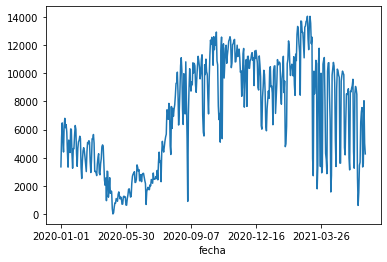

In [30]:
from matplotlib import pyplot
demanda_diaria["salidas"].sum().plot()
pyplot.show()

In [ ]:
## DEMANDA HORARIA

In [148]:
# del demanda_horaria
demanda_horaria = derivados["recorridos"]["df"]
# Fitro x dia
# demanda_horaria = demanda_horaria[demanda_horaria["fecha"] == '2020-01-01' ]
demanda_horaria = demanda_horaria.groupby(
    ['origen_nombre', 'origen_id','hora',]
).agg(
  salidas = ( 'hora',  'count'),
  total = ( 'origen_id',  'count'),
)
demanda_horaria = demanda_horaria.pivot_table(
    index = ['origen_nombre',  'origen_id', ],
    columns = ["hora"],
    values = ["salidas"],
    # aggfunc ='sum',
    fill_value =0,
).sort_values('origen_id')
demanda_horaria

# # print(demanda_horaria["salidas"])
# for h in demanda_horaria["salidas"].columns.to_list():
# #     demandas = demanda_horaria["salidas"][h]
#     estaciones = demanda_horaria["salidas"][h].reset_index()
#     for e in estaciones.iterrows():
#         estacion = e[1]
#         estacion_origen =  estacion['origen_id']
#         estacion_salidas =  estacion[h]
#         print(h, estacion_origen, estacion_salidas)
# # demanda_horaria
# for h in demanda_horaria.columns.to_list():
#     demandas = demanda_viz[h]
#     estaciones = demanda_viz[h].reset_index()
#     for e in estaciones.iterrows():
#         estacion = e[1]
#         print(h, estacion)
    

salidas                                     \
hora                               0    1    2    3    4    5    6    7    
origen_nombre       origen_id                                              
FACULTAD DE DERECHO 1             395  252  148  102   76  151  440  598   
RETIRO I            2              72   30   12    6    5   59  120  255   
ADUANA              3              99   84   44   20   25  167  204  509   
PLAZA ROMA          4              79   41   29   21   13   67  160  238   
PLAZA ITALIA        5             655  533  408  231  129  337  376  807   
...                               ...  ...  ...  ...  ...  ...  ...  ...   
BARRIO 31           393            93   63   27   14   37  466  460  257   
AV. LA PLATA        394             1    2    0    1    0    6   13   41   
AGRONOMIA II        395             7    5    3    3    0   10    0    7   
PLAZA ALBERTI       396           384  323  165   91   50   84  250  384   
GARCIA DEL RIO      399           534  323  208  160   89   99  193  396   

                                           ...                                \
hora                             8     9   ...    14    15    16    17    18   
origen_nombre       origen_id              ...                                 
FACULTAD DE DERECHO 1           938   904  ...  1697  2303  3026  3491  3795   
RETIRO I            2           336   440  ...   563   596   654   780   843   
ADUANA              3           614   601  ...   848   907   844   685   530   
PLAZA ROMA          4           363   433  ...   407   528   625   703   511   
PLAZA ITALIA        5          1197  1044  ...  1917  2299  2695  3017  3124   
...                             ...   ...  ...   ...   ...   ...   ...   ...   
BARRIO 31           393         494   246  ...   342   449   515   647   532   
AV. LA PLATA        394          22    12  ...    37    65    77    95    71   
AGRONOMIA II        395          14    43  ...    28    59    74    63    64   
PLAZA ALBERTI       396         685   838  ...  1168  1435  1527  1777  1940   
GARCIA DEL RIO      399         820  1037  ...  1361  1825  2234  2541  2897   

                                                           
hora                             19    20    21   22   23  
origen_nombre       origen_id                              
FACULTAD DE DERECHO 1          3724  2632  1564  802  519  
RETIRO I            2           397   322   271  153   82  
ADUANA              3           367   260   197  141  147  
PLAZA ROMA          4           350   201   131  125   93  
PLAZA ITALIA        5          2598  2226  1316  932  767  
...                             ...   ...   ...  ...  ...  
BARRIO 31           393         308   238   190  161  111  
AV. LA PLATA        394          43    40    19   11   13  
AGRONOMIA II        395          49    22    29   10    6  
PLAZA ALBERTI       396        1623  1380   970  638  560  
GARCIA DEL RIO      399        2741  2403  1640  942  714  

[236 rows x 24 columns]

In [ ]:
# https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
# TOTAL HORARIO
# del demanda_horaria
# demanda_horaria = derivados["recorridos"]["df"]
# # Fitro x dia
# # demanda_horaria = demanda_horaria[demanda_horaria["fecha"] == '2020-01-01' ]
# demanda_horaria = demanda_horaria.groupby(
#     ['origen_nombre', 'origen_id','hora',]
# ).agg(
# #   total = ( ['hora','origen_id'],  'count'),
#   salidas = ( 'hora',  'count'),
#   total = ( 'origen_id',  'count'),
# #   fill_values = 0,
# )
# # .reset_index()
# # df.set_index(['id', 'date', 'location'], append=True)
# demanda_horaria = demanda_horaria.pivot_table(
#     index = ['origen_nombre',  'origen_id', "total"],
#     columns = ["hora" ],
#     values = ["salidas","total"],
#     # aggfunc ='sum',
#     fill_value =0,
# ).sort_values('origen_id')
# demanda_horaria

### SUMINISTRO HORARIO




In [ ]:
suministro_horario = derivados["recorridos"]["df"].groupby(
    [ 'destino_nombre',  'destino_id', 'hora' ]
).agg(
  salidas = ( 'hora',  'count'),
)
suministro_horario = suministro_horario.pivot_table(
    index = ['destino_nombre',  'destino_id'],
    columns = "hora",
    values = "salidas",
    # aggfunc = 'sum',
).sort_values('destino_id')
suministro_horario

In [ ]:
# demanda_diaria = derivados["recorridos"]["df"].groupby(
#     ['origen_nombre', 'origen_id','wdia']
# ).agg(
#   salidas = ( 'wdia',  'count'),
# )
# demanda_diaria = demanda_diaria.pivot_table(
#     index   = ['origen_nombre',  'origen_id'],
#     columns = "wdia",
#     values  = "salidas",
#     # aggfunc = 'count',
# ).sort_values('origen_id')
# demanda_diaria 

## SALIDAS Y ARRIBOS

In [20]:
# # derivados["estaciones"]["df"]
# derivados["estaciones"]["df"] = pd.merge(
#     left     = derivados["estaciones"]["df"],
#     right    = insumos["estaciones"]["df"],
#     how      = 'right', 
#     left_on  = ['id'], 
#     right_on = ['codigo']
# )

In [ ]:
# # orden_filtro = {
# #       'codigo' : 'id'
# #       'direccion' : 'direccion',
#         'nombre_y'
# # }
# # derivados["estaciones"]["df"] = derivados["estaciones"]["df"].rename( columns = orden_filtro )
# # derivados["estaciones"]["df"] = derivados["estaciones"]["df"][ list( orden_filtro.values() ) ]
# derivados["estaciones"]["df"].columns.tolist()

## FEATURE DISCOVERY

### duracion_cat (catergories)

In [ ]:
# DURACION EN MINUTOS 
derivados["recorridos"]["df"].eval('duracion_mins = duracion / 60', inplace = True)
derivados["recorridos"]["df"]["duracion_mins"] = derivados["recorridos"]["df"]["duracion_mins"].astype(int)
# MINUTOS TO CATEGORIES
# labels = [ "{0}-{1}".format(i, i + 15) for i in range(0, 265, 15) ]
dur_cortes    = [ 0,     5,   15,  30,    45,  60,   90,  120,  240, 320, 60000 ]
dur_etiquetas = [ 'XXS', 'XS', 'S', 'SM', 'M', 'ML', 'L', 'XL', 'XXL', 'OS' ]
derivados["recorridos"]["df"]["duracion_cat"] = pd.cut( 
    derivados["recorridos"]["df"].duracion_mins,
    dur_cortes,
    include_lowest = True,
    labels = dur_etiquetas
   # right = False,
)
derivados["recorridos"]["df"]['duracion_cat'].unique()

In [ ]:
# derivados["recorridos"]["df"][derivados["recorridos"]["df"]['duracion_cat'] == 'M' ]

### TIPO DE RECORRIDO: VUELTA / IDA

In [ ]:
derivados["recorridos"]["df"]['vuelta'] = np.where( 
  derivados["recorridos"]["df"]['origen_id'] == derivados["recorridos"]["df"]['destino_id'], 1, 0
)

In [ ]:
# FILTRAR VUELTAs y duracion_cat
vueltas = derivados["recorridos"]["df"][ derivados["recorridos"]["df"]['vuelta'] == 1]
vueltas[ vueltas['duracion_cat'] == 'OS'  ].sort_values("duracion_mins", ascending = False)


### DISTANCIAS


In [58]:
!pip install openrouteservice

In [54]:
# estaciones = [ x for x in derivados["estaciones"]["df"].iterrows() ]
estaciones = [ x for x in derivados["estaciones"]["df"].set_index('id').sort_values('id').iterrows() ]

del rutas
rutas = {}
nid = 0
for o in estaciones:
    origen_id = int(o[0])
    # https://ask.openrouteservice.org/t/could-not-find-point-within-a-radius-of-350-0-meters/2668/16
    origen_coords = ( o[1]['lon'], o[1]['lat'] ) # ORS takes lon,lat 
    for d in estaciones:
        destino_id = int(d[0])
        destino_coords = ( d[1]['lon'], d[1]['lat'] ) # ibidem
        ruta_id = str( origen_id ) + 'to' + str( destino_id )
        vuelta_id = str( destino_id) + 'to' + str( origen_id )
        ruta = {
          "id" : ruta_id,
          "nid" : nid,
          "origen_id": origen_id,
          "destino_id": destino_id,
          "coords" : ( origen_coords, destino_coords ),
          "distancia" : 0,
          "duracion_estimada" : 0,
          "consultar" : ( origen_id != destino_id ),
          "complemetaria" : vuelta_id,
          "preexiste" : (ruta_id in rutas or vuelta_id in rutas),
        }
        nid+=1
        rutas[ruta_id] = ruta
print( 'rutas:', len( rutas ) )

# del rutas_calcular
rutas_calcular = {}
chunk = 0
cuenta_rutas = 0
for r in rutas:
    ruta = rutas[r]
    if ruta['consultar'] and not ruta["preexiste"]:
        if( (cuenta_rutas % 2000) == 0 ): # due to ors dayly cuota
            chunk = chunk + 1  
        ruta["chunk"] = chunk
        rutas_calcular[r] = ruta
        cuenta_rutas = cuenta_rutas + 1
print( 'rutas a calular:', len( rutas_calcular ) )



rutas: 52441
rutas a calular: 26106


In [55]:
cuenta = 0
for r in rutas_calcular:
    ruta = rutas_calcular[r]
    if ruta["chunk"] == 1:
        cuenta += 1
print(cuenta)

2000


In [ ]:
rutas_calcular
rutas_calculadas = derivados["rutas"]["df"] 

In [71]:
derivados["rutas"]["df"] = pd.read_csv(
  derivados["rutas"]["local"],
)
print(len(derivados["rutas"]["df"].index))

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/rutas_estaciones.csv'

In [59]:
from time import sleep
import openrouteservice as ors

ors_client = ors.Client(
    key = '5b3ce3597851110001cf624827a63bd0239f438caa1f7504352a9fc8'
) 
# del rutas_calculadas
# rutas_calculadas = pd.DataFrame()

# derivados["rutas"]["df"]  = pd.read_csv(
#   derivados["rutas"]["local"],
# )

# CARGAR RUTAS YA CALCULDAS
rutas_calculadas = derivados["rutas"]["df"] 
cuenta_calculadas = 1
for rc in rutas_calcular:
    ruta = rutas[rc]
    if ruta['chunk'] == 2: # ya hice el chunk 1
        if ( ( cuenta_calculadas % 40) == 0): # due to ors minute cuota
            print( 'durmiendo', cuenta_calculadas )
            print( 'rutas calculadas:', len(rutas_calculadas.index) )
            rutas_calculadas
            sleep(60)
        ruta['directions'] = ors_client.directions(
          ruta['coords'],
          profile = 'cycling-regular',
        )
        cuenta_calculadas = cuenta_calculadas + 1
        rutas_calculadas = rutas_calculadas.append(
           ruta,
           ignore_index = True
        )
print( 'rutas calculadas hoy:', len(rutas_calculadas.index))
# rutas_df = pd.concat(   derivados["rutas"]["df"] , rutas_calculadas ] )

rutas_calculadas.to_csv(
  derivados["rutas"]["local"],
  index = False,
)
# rutas_df.reset_index()

durmiendo 40
rutas calculadas: 39
durmiendo 80
rutas calculadas: 79
durmiendo 120
rutas calculadas: 119
durmiendo 160
rutas calculadas: 159
durmiendo 200
rutas calculadas: 199
durmiendo 240
rutas calculadas: 239
durmiendo 280
rutas calculadas: 279
durmiendo 320
rutas calculadas: 319
durmiendo 360
rutas calculadas: 359
durmiendo 400
rutas calculadas: 399
durmiendo 440
rutas calculadas: 439
durmiendo 480
rutas calculadas: 479
durmiendo 520
rutas calculadas: 519
durmiendo 560
rutas calculadas: 559
durmiendo 600
rutas calculadas: 599
durmiendo 640
rutas calculadas: 639
durmiendo 680
rutas calculadas: 679
durmiendo 720
rutas calculadas: 719
durmiendo 760
rutas calculadas: 759
durmiendo 800
rutas calculadas: 799
durmiendo 840
rutas calculadas: 839
durmiendo 880
rutas calculadas: 879
durmiendo 920
rutas calculadas: 919
durmiendo 960
rutas calculadas: 959
durmiendo 1000
rutas calculadas: 999
durmiendo 1040
rutas calculadas: 1039
durmiendo 1080
rutas calculadas: 1079
durmiendo 1120
rutas calcul

In [61]:
# print(len(rutas_calculadas.index))
rutas_calculadas

,chunk,complemetaria,consultar,coords,destino_id,directions,distancia,duracion_estimada,id,nid,origen_id,preexiste
0,1.0,1to0,1.0,"((-58.3897856456985, -34.6427424928089), (-58....",1.0,"{'routes': [{'summary': {'distance': 7773.0, '...",0.0,0.0,0to1,1.0,0.0,0.0
1,1.0,2to0,1.0,"((-58.3897856456985, -34.6427424928089), (-58....",2.0,"{'routes': [{'summary': {'distance': 7162.0, '...",0.0,0.0,0to2,2.0,0.0,0.0
2,1.0,3to0,1.0,"((-58.3897856456985, -34.6427424928089), (-58....",3.0,"{'routes': [{'summary': {'distance': 5293.6, '...",0.0,0.0,0to3,3.0,0.0,0.0
3,1.0,4to0,1.0,"((-58.3897856456985, -34.6427424928089), (-58....",4.0,"{'routes': [{'summary': {'distance': 6481.4, '...",0.0,0.0,0to4,4.0,0.0,0.0
4,1.0,5to0,1.0,"((-58.3897856456985, -34.6427424928089), (-58....",5.0,"{'routes': [{'summary': {'distance': 8829.6, '...",0.0,0.0,0to5,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,348to8,1.0,"((-58.3893329884138, -34.6094227344644), (-58....",348.0,"{'routes': [{'summary': {'distance': 11506.1, ...",0.0,0.0,8to348,2040.0,8.0,0.0
1996,1.0,349to8,1.0,"((-58.3893329884138, -34.6094227344644), (-58....",349.0,"{'routes': [{'summary': {'distance': 8616.5, '...",0.0,0.0,8to349,2041.0,8.0,0.0
1997,1.0,350to8,1.0,"((-58.3893329884138, -34.6094227344644), (-58....",350.0,"{'routes': [{'summary': {'distance': 7789.6, '...",0.0,0.0,8to350,2042.0,8.0,0.0
1998,1.0,352to8,1.0,"((-58.3893329884138, -34.6094227344644), (-58....",352.0,"{'routes': [{'summary': {'distance': 8677.7, '...",0.0,0.0,8to352,2043.0,8.0,0.0


In [64]:
rutas_df = pd.read_csv(
  derivados["rutas"]["local"],
)
# rutas_df
print(len(rutas_df.index))


2000


In [ ]:
# GEOPY

# import geopy

# # DF DISTANCIAS
# distancias = pd.DataFrame()
# estaciones = [ x for x in derivados["estaciones"]["df"].set_index('id').sort_values('id').iterrows() ]
# for o in estaciones:
#   print(cuenta_calls)
#   origen_id = int( o[0] )
#   origen_geocoords = ( o[1]['lat'], o[1]['lon'] )
#   # distancias[origen_id] = {}
#   for d in estaciones:
#     destino_id = int( d[0] )
#     destino_geocoords = ( d[1]['lat'], d[1]['lon'] ) 
#     fila = {
#       "id"  : str(origen_id) + 'to' + str(destino_id),
#       "origen_id": origen_id,
#       "destino_id": destino_id,
#       "distancia" : 0,
#     }
#     if (
#         destino_id != origen_id
#     ): 
#       geocoords = ( origen_coords, destino_coords )
#       distancia = round( 
#         geopy.distance.vincenty( origen_geocoords, destino_geocoords ).km, 
#         2
#       ) 
#       fila["distancia"] = distancia
#     distancias = distancias.append( fila, ignore_index = True )
# distancias['origen_id'] = distancias['origen_id'].astype(int)
# distancias
# distancias.to_csv(
#   datadir + 'distancias.csv',
#   index = False,
# )

In [69]:
derivados["distancias"]["df"] = pd.read_csv(
  derivados["distancias"]["local"]
)
# rutas_df
print(len(derivados["distancias"]["df"].index))

200


In [70]:
derivados["distancias"]["df"].reset_index()
# hay que reyeipear a un registro por cada combineta


,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,365,373,374,381,384,387,391,393,396,399
0,1,0.00,1.75,3.66,2.83,2.81,5.32,2.67,2.85,1.58,...,9.21,4.46,6.81,4.36,5.60,6.14,3.44,1.09,7.00,8.73
1,2,1.75,0.00,2.15,1.18,4.44,4.03,1.67,2.31,3.13,...,10.01,3.78,7.53,6.08,6.68,5.61,5.19,1.17,8.74,10.46
2,3,3.66,2.15,0.00,1.02,5.90,1.95,1.28,1.94,4.60,...,9.91,2.49,7.47,7.68,7.15,4.20,7.00,3.32,10.35,12.02
3,4,2.83,1.18,1.02,0.00,5.34,2.96,1.24,2.07,4.01,...,10.13,3.16,7.65,7.06,7.08,4.96,6.26,2.34,9.73,11.44
4,5,2.81,4.44,5.90,5.34,0.00,7.10,4.65,4.32,1.33,...,7.33,5.56,5.26,1.81,3.56,6.73,1.70,3.87,4.46,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,387,6.14,5.61,4.20,4.96,6.73,2.96,3.95,3.37,5.94,...,6.87,1.83,4.84,8.39,5.64,0.00,8.37,6.52,10.72,12.09
196,391,3.44,5.19,7.00,6.26,1.70,8.44,5.85,5.69,2.54,...,8.70,7.08,6.81,1.32,4.99,8.37,0.00,4.29,3.65,5.39
197,393,1.09,1.17,3.32,2.34,3.87,5.18,2.68,3.15,2.67,...,10.19,4.73,7.76,5.33,6.64,6.52,4.29,0.00,7.92,9.66
198,396,7.00,8.74,10.35,9.73,4.46,11.52,9.11,8.76,5.75,...,8.44,9.86,7.49,2.68,5.67,10.72,3.65,7.92,0.00,1.74


### Data aligment / Pairing

In [67]:
# derivados["recorridos"]["df"]["distancia"] = 0
derivados["recorridos"]["df"] = pd.merge(
    left     = derivados["recorridos"]["df"],
    right    = distancias,
    how      = 'left', 
    left_on  = ['origen_id','destino_id'], 
    right_on = ['origen_id','destino_id']
)

KeyError: 'origen_id'

In [ ]:
derivados["recorridos"]["df"]["distancia"].max()

In [ ]:
# derivados["recorridos"]["df"]["distnacia"].unique()
dis_cortes    = [ 0,    2,   4,    6,   8,    10,   12,  14 ]
dis_etiquetas = [ 'XS', 'S', 'SM', 'M', 'ML', 'L', 'XL']
derivados["recorridos"]["df"]["distancia_cat"] = pd.cut( 
    derivados["recorridos"]["df"].distancia,
    dis_cortes,
    # include_lowest = True,
    labels = dis_etiquetas,
    ordered = True,
   # right = False,
)
derivados["recorridos"]["df"]['distancia_cat'].unique()

In [ ]:
derivados["recorridos"]["df"][derivados["recorridos"]["df"]["vuelta"] == 0 ]

### VELOCIDAD

In [ ]:
derivados["recorridos"]["df"].eval( 'velocidad_kmm = distancia / duracion_mins', inplace = True )
derivados["recorridos"]["df"][ derivados["recorridos"]["df"]["distancia_cat"] == "XL" ]

In [ ]:
column = derivados["recorridos"]["df"][ derivados["recorridos"]["df"]['velocidad_kmm'] != np.inf ]["velocidad_kmm"].dropna()
max_value = column.max()
mean_value = column.mean()
print(max_value)
print(mean_value)
derivados["recorridos"]["df"]["velocidad_kmm"].mean()

In [ ]:
vel_cortes    = [  0,      0.05,     0.1,    0.15,    0.2,     0.25,     0.3,         0.5,        0.7,      1 ]
vel_etiquetas = [ 'slento','lento','normal','nrapido','rapido','xrapido','xxrapido', 'xxxrapido', 'mrapido'   ]
derivados["recorridos"]["df"]["velocidad_cat"] = pd.cut( 
    derivados["recorridos"]["df"].velocidad_kmm,
    vel_cortes,
    include_lowest = True,
    labels = vel_etiquetas,
    ordered = True,
    # right = False,
)
derivados["recorridos"]["df"]['velocidad_cat'].unique()

In [ ]:
derivados["recorridos"]["df"][derivados["recorridos"]["df"]['velocidad_cat'] == 'slento']


### CLIMA
https://www.smn.gob.ar/descarga-de-datos
https://www.smn.gob.ar/datos-abiertos-smn


### Regular sequences: pd.date_range()

Regular date sequences 

In [ ]:
# Lista de dias a obtener
sdate = date(2020,1,1)  # start date
today = datetime.date.today()
yesterday = today - datetime.timedelta( days = 1 )
dias = pd.date_range(
  sdate, 
  yesterday - timedelta( days  1 ),
  freq='d'
)

### Observaciones Horarias
```
$ curl -v --silent https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/datohorario20210518.txt 2>&1 | grep AERO
!curl --silent https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/datohorario20210518.txt | head -n 1
!curl --silent https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/datohorario20210518.txt | grep AEROPARQUE

```

In [ ]:
!curl --silent https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/datohorario20210518.txt | grep AEROPARQUE

#### Pronostico
```
curl --silent https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=pron5d/pron20210101.txt | head -n 52
curl --silent https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=pron5d/pron20210101.txt | head -n 18
curl --silent https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=pron5d/pron20210101.txt | head -n 18 | tail -n 8 | awk '/1/ -F ":" {print $1,$2,$7}'
```

In [ ]:
!curl --silent https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=pron5d/pron20210101.txt | head -n 18 | tail -n 8 | awk '/1/ -F ":" {print $1,$2,$7}'

In [ ]:
""" Obtener datos horarios para cada dia  """
dh_formato = '%d%m%Y%H'
prefijo = 'https://ssl.smn.gob.ar/dpd/descarga_opendata.php?file=observaciones/datohorario'
sufijo = '.txt'
for i, d in enumerate(dias):
  dstr = d.strftime('%Y%m%d') 
  dato_horario = prefijo + dstr + sufijo
  req = urllib.request.Request( dato_horario )
  response = urllib.request.urlopen( req )
  lines = response.readlines()
  fecha = d.strftime('%Y-%m-%d')
  print(i, 'procesando', dato_horario)
  # encabezados = lines[0].decode("utf-8").split()  
  # ['FECHA', 'HORA', 'TEMP', 'HUM', 'PNM', 'DD', 'FF', 'NOMBRE']
  # [b'[HOA]', b'[\xbaC]', b'[%]', b'[hPa]', b'[gr]', b'[km/hr]']
  # fstl = lines[2].decode("utf-8").split()  
  # print( encabezados )
  # print( fstl )
  
  for l in lines:
    if b'AEROPARQUE' in l:
      row =  l.decode("utf-8").split()
      # dh = str(row[0]) + str(row[1])
      # dh_dt = pd.to_datetime(
      #   dh, 
      #   format = dh_formato
      # ) 
      dh_dic = {
        # 'DH_DT'   : dh_dt,
        'FECHA'   : fecha,
        'HORA'    : row[1],
        'TEMP'    : row[2], 
        'HUM'     : row[3], 
        'PNM'     : row[4], 
        'DD'      : row[5], 
        'FF'      : row[6], 
        # 'NOMBRE'  : row[7]
      }
      derivados["clima"]["df"] = derivados["clima"]["df"].append(
        dh_dic,
        ignore_index=True
      )

In [ ]:
# CARGAR CLIMA
derivados["clima"]["df"] = pd.read_csv(
  derivados["clima"]["local"],
)
derivados["clima"]["df"].info()

In [ ]:
# formato = '%Y-%m-%d'
# derivados["clima"]["df"]['DATE'] = pd.to_datetime(
#   derivados["clima"]["df"]['DATE'], 
#   format = formato
# )
# # derivados["clima"]["df"]['TAVG'].unique()
# derivados["clima"]["df"]['TEMP'].unique()

In [ ]:
derivados["recorridos"]["df"] = pd.merge(
    left     = derivados["recorridos"]["df"],
    right    = derivados["clima"]["df"],
    how      = 'left', 
    left_on  = ['fecha','hora'], 
    right_on = ['FECHA','HORA']
)
derivados["recorridos"]["df"]

In [ ]:
derivados["recorridos"]["df"] = pd.merge(
    left     = derivados["recorridos"]["df"],
    right    = insumos["clima"]["df"],
    how      = 'left', 
    left_on  = 'fecha', 
    right_on = 'DATE'
)

In [ ]:
orden = [
#  'id',
#  'estado_cerrado',
  'usuario_id',
  'origen_id',
  'origen_nombre',
  # 'origen_fecha',
  # 'origen_direccion',
  # 'origen_lon',
  # 'origen_lat',
  'destino_id',
  'destino_nombre',
#  'destino_fecha',
#  'destino_direccion',
#  'destino_lon',
#  'destino_lat',
  'vuelta', 
  'duracion',
  'duracion_mins',
  'duracion_cat',
  'distancia',
  'distancia_cat',
  'velocidad_kmm',
  'velocidad_cat',
  'origen_datetime',
  'fecha',
  'wdia',
  'hora',
  'dhabil',
  'DD',
  'FF',
  'HUM',
  'PNM',
  'TEMP',
  'PRCP',
  'TAVG',
#  'FECHA',
#  'HORA',
#  STATION	NAME	LATITUDE	lonITUDE	ELEVATION	DATE
#  PRCP_ATTRIBUTES
#  TAVG_ATTRIBUTES	TMAX	TMAX_ATTRIBUTES	TMIN	TMIN_ATTRIBUTES                                                
]
derivados["recorridos"]["df"] = derivados["recorridos"]["df"][ orden ]
derivados["recorridos"]["df"]

In [ ]:
# recorridos_clima 
derivados["recorridos"]["df"].to_csv(
  derivados["recorridos"]["local"],
  index = False,
)

In [ ]:
derivados["recorridos"]["df"].info()

In [ ]:
# GRUPING USERS
usurios = derivados["recorridos"]["df"].groupby(
    ['usuario_id']
).agg(
  salidas = ( 'destino_id',  'count'),
  vueltas = ( 'vuelta',  'sum'),
  velocidad = ( 'velocidad_kmm',  'max'),
  distancia = ( 'distancia',  'max')
)
# usurios = usurios.pivot_table(
#     index   = [ 'usuario_id'],
#     columns = "salidas",
#     values  = "salidas",
#     # aggfunc = 'count',
# ).sort_values('origen_id')
# demanda_diaria # comprobar

In [ ]:
usurios = usurios[ ~usurios.isin([np.nan, np.inf, -np.inf]).any(1) ]
# usurios
usurios.sort_values( 'velocidad' , ascending = False).head(30)

# Analisis Exploratorio de Datos Espaciales



In [ ]:
# demanda_viz = derivados["recorridos"]["df"]
# # Fitro x dia

# demanda_viz = demanda_viz[ demanda_viz["fecha"] == '2020-01-01' ]
# demanda_viz

## Exploratory Spatial Data Analysis (ESDA)

https://alcidanalytics.com/p/geographic-heatmap-in-python

https://alysivji.github.io/getting-started-with-folium.html

https://medium.com/analytics-vidhya/measure-driving-distance-time-and-plot-routes-between-two-geographical-locations-using-python-39995dfea7e

In [36]:
demanda_viz = derivados["recorridos"]["df"]
# Fitro x dia
fecha_viz   = '2020-03-01'
demanda_viz = demanda_viz[ demanda_viz["fecha"] == fecha_viz ]
demanda_viz = demanda_viz.groupby(
    ['origen_nombre', 'origen_id', 'hora', 'origen_lon','origen_lat']
).agg(
  salidas = ( 'hora',  'count' ),
  nombre  = ( 'origen_nombre',  'first' ),
  id      = ( 'origen_id',  'first' ),
  lon     = ( 'origen_lon',  'first' ),
  lat     = ( 'origen_lat',  'first' ),
)
# ).reset_index()
# df.set_index(['id', 'date', 'location'], append=True)
demanda_viz = demanda_viz.pivot_table(
    index = ['nombre',  'id', 'lon','lat'],
    columns = "hora",
    values = "salidas",
    fill_value = 0,
    # aggfunc = 'sum',
).sort_values('id')

In [ ]:
# import folium
# from folium import plugins
# # import pandas as pd
# # import matplotlib.pyplot as plt
# import seaborn as sns

# %matplotlib inline

In [35]:
#... where m is my map object. And 5 is the time (seconds) to render the map.
# https://stackoverflow.com/questions/53565979/export-a-folium-map-as-a-png
# https://blog.ouseful.info/2015/12/15/grabbing-screenshots-of-folium-produced-choropleth-leaflet-maps-using-selenium/
# from time import sleep
import io
from PIL import Image

# !pip install folium selenium
import folium 
from folium.features import DivIcon
import selenium

import math
def mapear(x): 
    return int( (x / 10 ) * 255)



In [37]:
# del m
m = ''
for h in demanda_viz.columns.to_list():
    del m
    m = folium.Map(
#         [ -34.606499,-58.381094 ], # obelisco
        [-34.606739, -58.435539 ], # parque centenario
        zoom_start = 13,
        zoom_control=False,
        scrollWheelZoom=False,
        dragging=False
#         tiles='stamentoner'
    )
    folium.map.Marker(
        [ -34.559920, -58.372211 ],
        icon = DivIcon(
            icon_size=(600,400),
            icon_anchor=(0,0),
            html='<div style="font-size: 20pt;font-family: monospace;">' \
            + fecha_viz + ' HORA:' + "{:02d}".format( h ) \
            + '</div>',
        )
    ).add_to(m)
    demandas = demanda_viz[h]
    estaciones = demanda_viz[h].reset_index()
    for e in estaciones.iterrows():
        estacion = e[1]
        folium.CircleMarker(
            [ estacion['lat'], estacion['lon'] ],
            radius = estacion[h] * 5, 
            popup = "{0}\:{1}\demanda:{2}".format(
                estacion['id'],
                estacion['nombre'],
                str(estacion[h]),
            ),
            fill_color = "#{0:02x}{1:02x}{2:02x}".format(
                mapear( int(estacion[h]) ),
                255 - mapear( int(estacion[h]) ) ,
                255 - mapear( int(estacion[h]) )
            )
        ).add_to(m)
    m.save( 'ESDA/' + fecha_viz + '_' + "{:02d}".format( h ) + '_' + 'map.html')
    
#     img_data = m._to_png(5)
#     img = Image.open(io.BytesIO(img_data))
#     img.save( 'ESDA/' + fecha_viz + '_' + "{:02d}".format( h ) + '_' + 'map.png' )

In [39]:
!convert -density 72 'ESDA/2020-03-01_00_map.html' '2020-03-01_00_map.html'


convert: delegate failed `'html2ps' -U -o '%o' '%i'' @ error/delegate.c/InvokeDelegate/1913.
convert: unable to open file '/tmp/magick-M5JyQ2DIVzxu8InIWacACyPeIY4mru0j': No existe el fichero o el directorio @ error/constitute.c/ReadImage/611.
convert: no images defined `2020-03-01_00_map.html' @ error/convert.c/ConvertImageCommand/3322.


In [19]:
# !ffmpeg -pattern_type glob -i './ESDA/*.png' -vf zoompan=z=1:d=4:s=1366x683:fps=5,framerate=25 -vcodec libx264 -acodec aac ESDA.mp4
!ffmpeg -pattern_type glob -i './ESDA/*.png' -vf zoompan=z=1:d=4:s=1366x683:fps=5,framerate=25 -vcodec libx264 -an ESDA.mp4

ffmpeg version n4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid --e

## reserva

In [43]:
# # !pip install ffmpeg-python
# import ffmpeg
# # stream = ffmpeg.input('input.mp4')
# # stream = ffmpeg.hflip(stream)
# # stream = ffmpeg.output(stream, 'output.mp4')
# # ffmpeg.run(stream)
# del stream
# stream = ffmpeg.input( 'ESDA/*.png', pattern_type = 'glob', framerate = 24 )
# stream = ffmpeg.output( stream, 'ESDA.mp4')
# ffmpeg.run(stream)


(None, None)

In [ ]:
# import math
# def mapear(x): 
#   return int( (x / 30295 ) * 255) 
# m = folium.Map(
#   [ -34.606499,-58.381094 ],
#   zoom_start = 14
# )
# #  mark each station as a point
# for e in derivados["estaciones"]["df"].iterrows():
#   folium.CircleMarker(
#       [ estacion['lat'], estacion['lon'] ],
#       radius= estacion['salidas'] * 0.002, 
#       popup = "{0}\nsalidas:{1}\narribos:{2}".format(
#           estacion['nombre'],
#           str(estacion['salidas']),
#           str(estacion['arribos'])
#       ),
#       fill_color = "#{0:02x}{1:02x}{2:02x}".format(
#           mapear( int(estacion['salidas']) ),
#           255 - mapear( int(estacion['salidas']) ) ,
#           255 - mapear( int(estacion['salidas']) )
#       )
#   ).add_to(m)
# m

In [ ]:
# # convert to (n, 2) nd-array format for heatmap
# # stationArr = derivados["estaciones"]["df"][['lat', 'lon']].as_matrix()
# # https://stackoverflow.com/a/63293803
# stationArr = derivados["estaciones"]["df"][['salidas']].values

# # plot heatmap
# m.add_children(plugins.HeatMap(stationArr, radius=15))
# m

In [ ]:
"""
We will create a helper function with default keyword arguments to abstact away
Folium's complexity. This leaves us with a simple API we can use going forward.
https://alysivji.github.io/getting-started-with-folium.html
"""
def map_points(
    df,
    lat_col = 'lat',
    lon_col = 'lon',
    zoom_start = 11, 
    plot_points = False,
    pt_radius = 15, 
    draw_heatmap = False,
    heat_map_weights_col = None, 
    heat_map_weights_normalize = False,
    heat_map_radius = 15,
    popup_name = 'nombre'
):
  """
  Creates a map given a dataframe of points. 
  Can also produce a heatmap overlay

  Arg:
    df: dataframe containing points to maps
    lat_col: Column containing latitude (string)
    lon_col: Column containing lonitude (string)
    zoom_start: Integer representing the initial zoom of the map
    plot_points: Add points to map (boolean)
    pt_radius: Size of each point
    draw_heatmap: Add heatmap to map (boolean)
    heat_map_weights_col: Column containing heatmap weights
    heat_map_weights_normalize: Normalize heatmap weights (boolean)
    heat_map_radius: Size of heatmap point
    popup_name: name of the popup

  Returns:
      folium map object
  """

  ## center map in the middle of points center in
  middle_lat = df[lat_col].median()
  middle_lon = df[lon_col].median()

  curr_map = folium.Map(
      location=[middle_lat, middle_lon],
      zoom_start=zoom_start
  )
  cols_to_pull = [ lat_col, lon_col, heat_map_weights_col ]
  # add points to map
  if plot_points:
    for _, row in df.iterrows():
      folium.CircleMarker(
        [ row[lat_col], row[lon_col] ],
        radius = pt_radius,
        popup = row[ popup_name ],
        fill_color = "#3db7e4", # divvy color
      ).add_to( curr_map )
  

  # add heatmap
  if draw_heatmap:
    # convert to (n, 2) or (n, 3) matrix format
    if heat_map_weights_col is None:
      cols_to_pull = [lat_col, lon_col]
    else:
      # if we have to normalize
      if heat_map_weights_normalize:
        df[ heat_map_weights_col] = df[heat_map_weights_col] / df[heat_map_weights_col].sum()
        cols_to_pull = [ lat_col, lon_col, heat_map_weights_col ]
      stations = df[cols_to_pull].values
      curr_map.add_children(
          plugins.HeatMap(
              stations,
              radius = heat_map_radius
          )
      )
  return curr_map

In [ ]:
# del m
m = map_points(
    derivados["estaciones"]["df"],
    plot_points = False,
    draw_heatmap = True,
    heat_map_weights_col = 'salidas',
    heat_map_weights_normalize = True,
)
m

In [ ]:
derivados["recorridos"]["df"].info()

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
# Fetch weather from drive
id = '14BpBfjQ3IrfeK8CajCWrEdfPg7S0eqc8'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('weather-data-ba.csv') 
weather_data_df = pd.read_csv('weather-data-ba.csv')
weather_data_df.head()
weather_data_df = weather_data_df.filter(
    ['DATE','PRCP','TAVG']
)
weather_data_df.isnull().sum( axis = 0 )
weather_data_df['PRCP'] = weather_data_df['PRCP'].replace( np.nan, 0 )
weather_data_df.head()

In [ ]:
bicicletas["recorridos_clima_df"].to_csv(
    '/drive/My Drive/Datasets-bicing/recorridos-clima-2020-2021.csv'
)

In [ ]:
bicicletas["recorridos_clima_df"].head()

## Bajar el ultimo
Bajar el dataset limpio desde drive

In [ ]:
from google.colab import files
files.download('recorridos_2020-2021.zip')

In [ ]:
bicicletas["recorridos_df"].to_csv(
    '/drive/My Drive/Datasets-bicing/recorridos_2020-2021.csv'
)

In [ ]:
id = '17liAPD1lyj2wT-Hcbh4ed9-Cn4peoyIq'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('recorridos_2020-2021.csv') 
bicicletas["recorridos_df"] = pd.read_csv('recorridos_2020-2021.csv')
bicicletas["recorridos_df"].head()